# Making Features Discrete
In previous weeks we have imputed values and made new variables using the `pandas.cut` function to define how to make a single attribute discrete. In this module, let's instead use clustering to convert one or more features into discrete, categorical features (integers). 

The process will be simple:
- Choose a subset of features from the dataset to cluster upon
- Cluster the features assuming according to a given algorithm
- Replace the features with their discrete cluster labels as a form of discretization
- Perform classification using the new feature from the dataset

In this notebook, we will investigate simple clustering methods for making the clusters discrete: kmeans, hierarchical agglomerative clustering, and DBSCAN. The dataset we will use comes from our titanic dataset that we have used in the past.

In [169]:
# load the Titanic dataset
import pandas as pd
import numpy as np

df = pd.read_csv('data/titanic.csv') # read in the csv file

# 1. Remove attributes that just arent useful for us
del df['PassengerId']
del df['Name']
del df['Cabin']
del df['Ticket']
del df['Embarked']

# 2. Impute some missing values, grouped by their Pclass and SibSp numbers
df_grouped = df.groupby(by=['Pclass','SibSp'])
# now use this grouping to fill the data set in each group, then transform back
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
df_imputed[['Pclass','SibSp']] = df[['Pclass','SibSp']]

# 3. drop rows that still had missing values after grouped imputation
df_imputed.dropna(inplace=True)
# 4. replace Sex with integers
df_imputed.Sex = df_imputed.Sex.replace(to_replace={'male':0, 'female':1})

# 5. Rearrange the columns
df_imputed = df_imputed[['Survived','Age','Sex','Parch','SibSp','Pclass','Fare']]

# 6. normalize distances for clustering continuos variables
df_imputed[['Age','Fare']] = (df_imputed[['Age','Fare']] - df_imputed[['Age','Fare']].mean()) / df_imputed[['Age','Fare']] .std()

print df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 0 to 890
Data columns (total 7 columns):
Survived    884 non-null int64
Age         884 non-null float64
Sex         884 non-null int64
Parch       884 non-null int64
SibSp       884 non-null int64
Pclass      884 non-null int64
Fare        884 non-null float64
dtypes: float64(2), int64(5)None


For this dataset, it probably makes sense to try and cluster `PClass` and `Fare` together because they have similar information and can likely be combined. It is unclear exactly where to make the classes discrete and how many levels we should make, so we will try a few different parameterizations to investigate this.

It also might make sense to make the `Age`, `Parch`, and `SibSp` cariables into a single discrete variable representing clusters of families. Again, we will need to try different parameterizations (numbers of cluster and the algorithm for clustering).

##Baseline Classification Performance
Let's start by performing 10 fold cross validation and using the raw features in a Random Forest classifer. Let's get the average accuracy of classifying whther a person survives or does not from the Titanic.

In [170]:
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y = df_imputed['Survived']
X = df_imputed[['Age','Sex','Parch','SibSp','Pclass','Fare']]
cv = StratifiedKFold(y,n_folds=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

Average accuracy =  80.7954545455 +- 4.75649596895


Okay, now let's start with a bit of feature engineering. We will start by using kmeans on `PClass` and `Fare` together.

In [171]:
from sklearn.cluster import KMeans
import numpy as np

X1 = df_imputed[['Pclass','Fare']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_imputed['Survived']
X = df_imputed[['Age','Sex','Parch','SibSp']]
X = np.column_stack((X,newfeature))

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100

Average accuracy (with kmeans for class/fare)=  80.5606060606 +- 4.3075627005


So it seems that the average accuracy of the folds has stayed about the same, but the deviation from the mean has been considerably decreased. Let's now try adding in different discretization of the features.

In [172]:
from sklearn.cluster import KMeans
import numpy as np

X1 = df_imputed[['Age','Parch','SibSp']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_imputed['Survived']
X = df_imputed[['Sex','Pclass','Fare']]
X = np.column_stack((X,newfeature))

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy (with kmeans for Age/Family)= ", acc.mean()*100, "+-", acc.std()*100

Average accuracy (with kmeans for Age/Family)=  80.654040404 +- 3.47064610693


This discretization actually helps increase the accuracy on average, but not really helping in the lowering of the deviation from the mean. What if we combine the different clusterings?

In [173]:
# get the first clustering
cls_fare = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_imputed['Survived']
X = df_imputed[['Sex']]
X = np.column_stack((X,newfeature_fare,newfeature_fam))

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

Average accuracy =  81.446969697 +- 2.83969221974


It seems this is not quite as accurate, but we still need to vary the parameters and see what works.

In [174]:
X1 = df_imputed[['Pclass','Fare']]
X2 = df_imputed[['Age','Parch','SibSp']]

params = []
for n_fare in range(3,5):
    for n_fam in range(20,25):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X1)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['Survived']
        X = df_imputed[['Sex']]
        X = np.column_stack((X,newfeature_fare,newfeature_fam))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print "Clusters",n_fare,n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

Clusters 3 20 Average accuracy =  81.2272727273 +- 3.3251966808
Clusters 3 21 Average accuracy =  80.6565656566 +- 3.33870473251
Clusters 3 22 Average accuracy =  80.8838383838 +- 3.79721072699
Clusters 3 23 Average accuracy =  81.7878787879 +- 3.66429369188
Clusters 3 24 Average accuracy =  79.9823232323 +- 3.66180859822
Clusters 4 20 Average accuracy =  80.7777777778 +- 2.93163873332
Clusters 4 21 Average accuracy =  80.7803030303 +- 3.25296145673
Clusters 4 22 Average accuracy =  82.1363636364 +- 4.02639933982
Clusters 4 23 Average accuracy =  80.6691919192 +- 4.36737660622
Clusters 4 24 Average accuracy =  81.1237373737 +- 4.1628425978


It seems that about the best we can do with these new discretization methods is around 80%. All the models are within one standard deviation of each other, so most clustering in this range are pretty reasonable. Let's see if we can make things better by only using one type of clustering.

In [175]:

params = []
for n_fam in range(7,15):

    # append on the clustering
    cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
    cls_fam.fit(X2)
    newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

    y = df_imputed['Survived']
    X = df_imputed[['Sex','Pclass','Fare']]
    X = np.column_stack((X,newfeature_fam))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

    print "Clusters",n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

Clusters 7 Average accuracy =  80.7853535354 +- 3.54656321697
Clusters 8 Average accuracy =  80.654040404 +- 3.47064610693
Clusters 9 Average accuracy =  80.8939393939 +- 2.97406141872
Clusters 10 Average accuracy =  82.9217171717 +- 3.35239137875
Clusters 11 Average accuracy =  80.6666666667 +- 2.65265006976
Clusters 12 Average accuracy =  81.6767676768 +- 2.97483322063
Clusters 13 Average accuracy =  81.2373737374 +- 3.38383838384
Clusters 14 Average accuracy =  80.898989899 +- 3.18332495988


So it seems that we can actually slightly increase the accuracy, with about 13 clusters we get the tightest standard deviation. Now, let's also try to replace features using some slightly different clustering algorithms and see what works best for classification.

In [176]:
from sklearn.cluster import AgglomerativeClustering

X1 = df_imputed[['Pclass','Fare']]

params = []
for n_fam in range(7,15):
    for link in ['ward', 'complete', 'average']:

        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['Survived']
        X = df_imputed[['Sex','Pclass','Fare']]
        X = np.column_stack((X,newfeature_fam))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print "C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

C= 7 ward Average accuracy =  82.0176767677 +- 3.16101605464
C= 7 complete Average accuracy =  82.25 +- 3.06161120442
C= 7 average Average accuracy =  81.6919191919 +- 4.38878427419
C= 8 ward Average accuracy =  81.4570707071 +- 3.43165094248
C= 8 complete Average accuracy =  81.6919191919 +- 3.54050850723
C= 8 average Average accuracy =  81.803030303 +- 4.59188130742
C= 9 ward Average accuracy =  81.9065656566 +- 3.17138440801
C= 9 complete Average accuracy =  82.1464646465 +- 3.45516932756
C= 9 average Average accuracy =  81.5833333333 +- 4.92174308496
C= 10 ward Average accuracy =  82.0126262626 +- 2.80569192952
C= 10 complete Average accuracy =  81.8080808081 +- 3.42828863175
C= 10 average Average accuracy =  82.0277777778 +- 4.42834621835
C= 11 ward Average accuracy =  81.904040404 +- 3.22673917911
C= 11 complete Average accuracy =  81.2373737374 +- 2.79701784872
C= 11 average Average accuracy =  82.5984848485 +- 5.07429309493
C= 12 ward Average accuracy =  81.1085858586 +- 3.3232

Again, all fairly good performances using different types of linkage and also different numbers of clusters. Let's now try DBSCAN.

In [177]:
from sklearn.cluster import DBSCAN

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts,random_state=1)
        cls_fam.fit(X2.values)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['Survived']
        X = df_imputed[['Sex','Pclass','Fare']]
        X = np.column_stack((X,newfeature_fam))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

0.1 5 Average accuracy =  82.1565656566 +- 5.0279445609
0.1 6 Average accuracy =  82.0429292929 +- 5.04373852275
0.1 7 Average accuracy =  81.3661616162 +- 5.80855784163
0.125 5 Average accuracy =  81.5909090909 +- 5.30668464757
0.125 6 Average accuracy =  82.2702020202 +- 5.03185255129
0.125 7 Average accuracy =  81.3661616162 +- 5.80855784163
0.15 5 Average accuracy =  81.5909090909 +- 5.30668464757
0.15 6 Average accuracy =  82.2702020202 +- 5.03185255129
0.15 7 Average accuracy =  81.3661616162 +- 5.80855784163


It seems that DBSCAN has good clusterings for this dataset that are able to capture some of the nuances for the attributes. Although this is not spatial data, it is interesting that contiguous clustering helps discretize the data a bit (for a small range of eps and minpts). Even so, the center based clustering also tend to do well.

##Visualizing different clusters
Now lets take the best performers from each dataset and show the clustering that they found in the data.

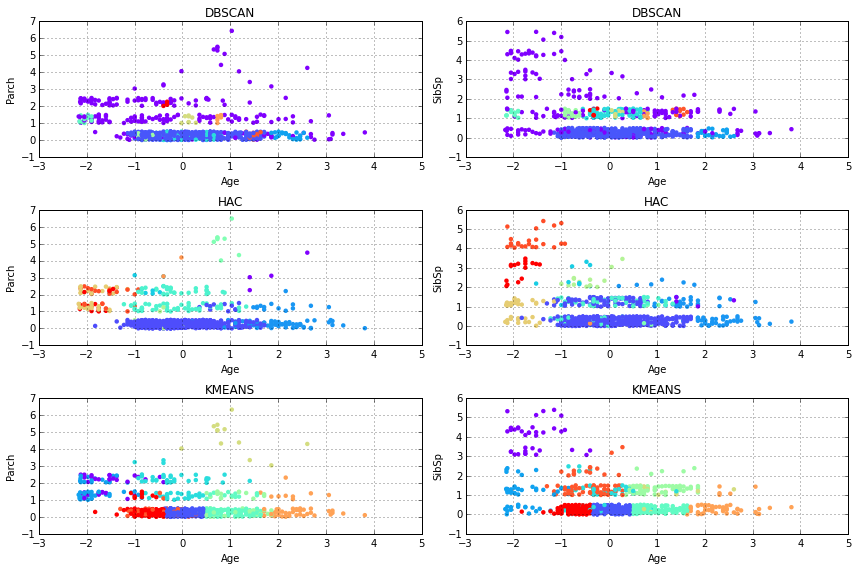

In [185]:
from matplotlib import pyplot as plt

%matplotlib inline

data = X2.values

cls = DBSCAN(eps=0.125, min_samples=6,random_state=1)
cls.fit(data)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=11, linkage='average')
cls.fit(data)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=10, random_state=1)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age'), plt.ylabel('Parch')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(data[:, 0], data[:, 2]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age'), plt.ylabel('SibSp')
    plt.grid()
    plt.title(title[i])
    
    


plt.tight_layout()
plt.show()